**XTREME GRADIENT BOOSTING**

**PART 1: REGRESSION**

Boosting is a technique to create ensemble models and boosting fits a series of models and fits each successive models to minimize the error of previous model. Its an optimized distributed gradient boosted lib that is designed to be scalable and efficient.

XgB is an ensemble of decision trees where new trees fix errors of the previous trees that are already part of the model and trees are added until no further improvement can be made. Generally you can fit tabular data, but you can fit time series data too. for that we need to make use of a walkforward validation instead of k fold as k fold may have some biased results

In [75]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from xgboost import XGBClassifier
plt.style.use(style = "seaborn")
%matplotlib inline

In [76]:
df = pd.read_csv("MSFT(1).csv")
#https://www.kaggle.com/prasoonkottarathil/microsoft-lifetime-stocks-dataset

In [77]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.062549,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.064783,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065899,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.064224,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.063107,47894400


In [78]:
df = df[["Close"]].copy()

In [79]:
df.head()

,Close
0,0.097222
1,0.100694
2,0.102431
3,0.099826
4,0.098090


We will have a univariate time series problem so making use just of the close. And then we need to convert it to a supervised learning problem

In order to do that we need to choose the next value

In [80]:
df["Target"] = df.Close.shift(-1)

In [81]:
df.dropna(inplace = True)

In [82]:
df.head(5)

,Close,Target
0,0.097222,0.100694
1,0.100694,0.102431
2,0.102431,0.099826
3,0.099826,0.098090
4,0.098090,0.095486


We are trying to predict the next hours close price

In [83]:
def train_test_split(data,perc):
    data = data.values
    n = int(len(data) * (1-perc))
    return data[:n], data[n:]

In [84]:
train, test = train_test_split(df, 0.2) #20% test set 80% train set

In [85]:
print(len(df))
print(len(test))
print(len(train))

8524
1705
6819


In [86]:
#https://xgboost.readthedocs.io/en/latest/
X = train[:,:-1]
y = train[:,-1]

In [87]:
X

array([[ 0.097222],
       [ 0.100694],
       [ 0.102431],
       ...,
       [28.16    ],
       [28.370001],
       [28.610001]])

In [88]:
y

array([ 0.100694,  0.102431,  0.099826, ..., 28.370001, 28.610001,
       28.610001])

In [89]:
model = XGBRegressor(objective = "reg:squarederror",n_estimators=10) 
#reg:squaredloss is our default learning task parameter which is our regression with squared loss
#https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
model.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

These are all the parameters that are specified by default. we can see that we are using a learning rate of 0.3

In [90]:
test[0]

array([28.610001, 28.799999])

Here we want to predict one step further in the test set so we see that we are getting a value of 28.61(first item/feature ) but we want to predict 28.79

In [91]:
val = np.array(test[0,0]).reshape(1,-1)
pred = model.predict(val)
print(pred[0])

#here we used the value of 28.61 and try to predict with the model we fit
# because we did it for just one sample the pediction is way off

27.7444


**Predict**

Now we will train on train set and predict one sample at a time

In [92]:
def xgb_predict(train,val):
    train = np.array(train)
    X,y = train[:,:-1], train[:,-1]
    model = XGBRegressor(objective ="reg:squarederror",n_estimators=10) 
    model.fit(X,y)
    val = np.array(val).reshape(1,-1)
    pred = model.predict(val)
    return pred[0]

In [93]:
xgb_predict(train, test [0, 0])

27.7444

Now that we have the XGBpredict method we need to create the validate method with Walk-forward validation technique - 
since we are making a one step forward prediction ( for this we are making an hourly prediction ) we are going to predict the first item in the test set and then the second item and so on. so for walk forward validation we use a train set and then we predict one step into the future (the next value) and then we add that to the train set and we retrain the model and then we predict the next item in the test set. Now this is added to our train set and the process repeats until we finish all the records in the test set
we predict one step at a time 


Evaluating the model with RSME

In [94]:
def validate(data,perc):
    predictions = []
    train, test = train_test_split(data,perc)
    history = [x for x in train]
    
    for i in range (len(test)):
        test_X,test_y = test[i,:-1], test[i,-1]
        pred = xgb_predict(history,test_X[0])
        predictions.append(pred)
        history.append(test[i])
    error = mean_squared_error(test[:,-1], predictions, squared = False)
    
    return error, test[:,-1], predictions
    

In [95]:
%%time 
rsme, y, pred = validate(df,0.2)
print(rsme)

D:\Anaconda\lib\site-packages\xgboost\data.py:94: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


3.8496480695644353
Wall time: 53.1 s


Since stock markets are very complex with dynamic data, so it is very hard to accurately predict. So we cannot use such models in real world scenarios. 

**PART 2: CLASSIFICATION**

In [127]:
from xgboost import XGBClassifier
XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [133]:
data = pd.read_csv("data(2).csv")
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [134]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,y,random_state=0,test_size=0.2)

In [135]:
model = XGBClassifier()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
from sklearn.metrics import accuracy_score,classification_report
print(classification_report(y_test,y_predict))
print(accuracy_score(y_test,y_predict))
pd.crosstab(y_test,y_predict)
#crosstab gives us the confusion matrix

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        47
           1       0.97      1.00      0.99        67

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

0.9824561403508771


col_0,0,1
row_0,,
0,45,2
1,0,67


0 is non cancer and 1 is cancer
1st case: we can see that there are 2 patients who dont have cancer but are being predicted as they so have cancer which is acceptable
2nd case: we can see that patients who do have cancer are being predicted correctly since the value is 0. if the value was any other number then we could tell that those many patients do have cancer but it is being predicted as they dont which is not acceptable.

In [136]:
model = XGBClassifier(max_depth = 2,
                      sub_sample = 0.8,
                      n_estimators =1000,
                      learning_rate = 0.05,
                      #random_state = 8,
                      min_child_weight =1,
                      )
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
from sklearn.metrics import accuracy_score
y_train_predict = model.predict(X_train)
print('Train accuracy : ',accuracy_score(y_train,y_train_predict))
print('Test accuracy : ',accuracy_score(y_test,y_predict))

[00:59:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train accuracy :  1.0
Test accuracy :  0.9824561403508771


These are found to be the best parameters by trial and error. 

In [137]:
col = data.columns      
print(col)

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


In [138]:
y = data.diagnosis                         
list = ['Unnamed: 32','id','diagnosis']
x = data.drop(list,axis = 1 )
x.head()



,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Number of Benign:  357
Number of Malignant :  212


C:\Users\Saket\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


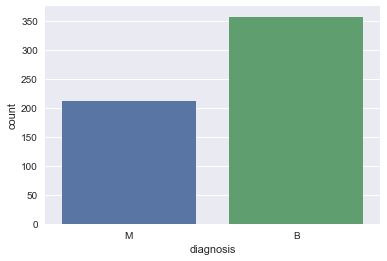

In [139]:
ax = sns.countplot(y,label="Count")      
B, M = y.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)



In [140]:
x.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'radius_mean'),
  Text(1, 0, 'texture_mean'),
  Text(2, 0, 'perimeter_mean'),
  Text(3, 0, 'area_mean'),
  Text(4, 0, 'smoothness_mean'),
  Text(5, 0, 'compactness_mean'),
  Text(6, 0, 'concavity_mean'),
  Text(7, 0, 'concave points_mean'),
  Text(8, 0, 'symmetry_mean'),
  Text(9, 0, 'fractal_dimension_mean')])

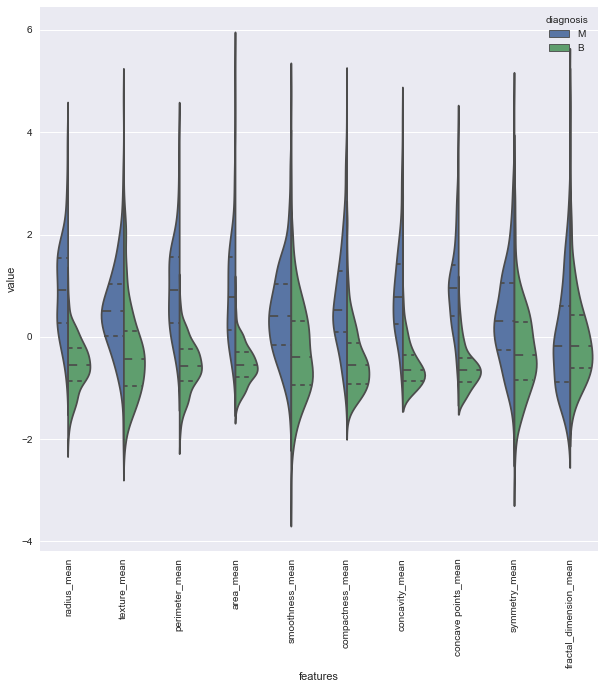

In [141]:
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())             
data = pd.concat([y,data_n_2.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

median of M and B in texture_mean look like they are separate which means it is good for classification 
whereas in case of fractal_dimension_mean it does not so we cannot use it


<AxesSubplot:>

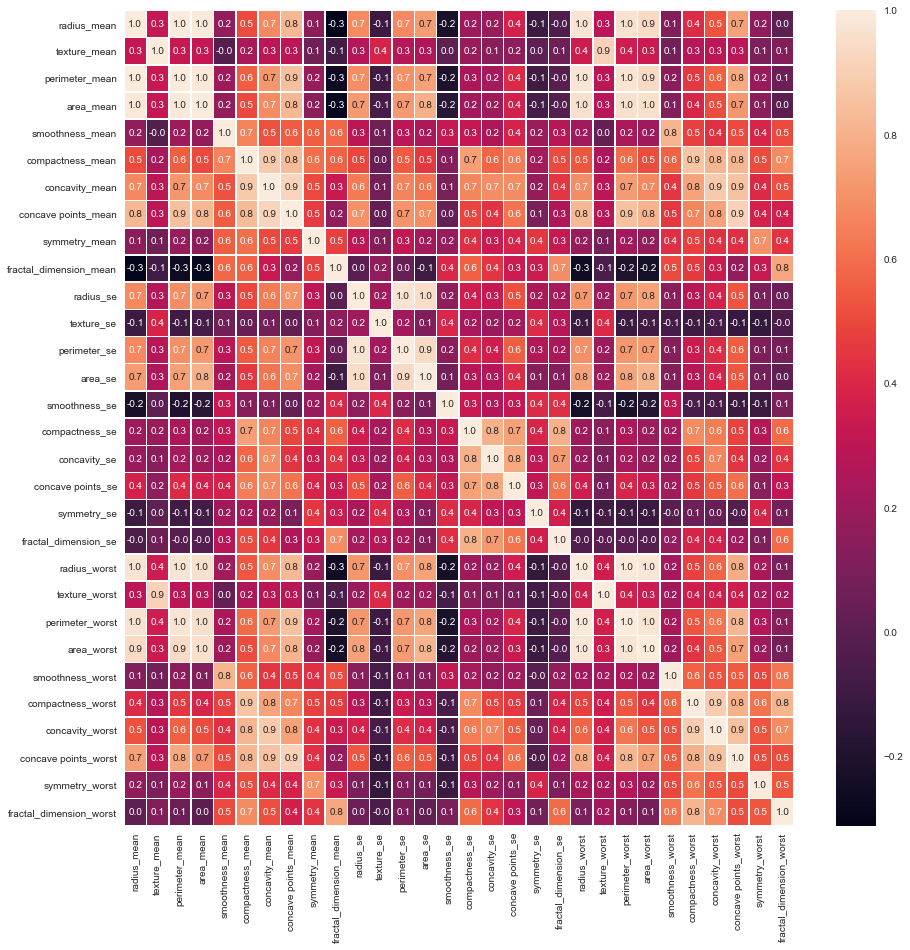

In [145]:
#correlation map
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

correlation between all features

C:\Users\Saket\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 41.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Saket\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 41.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Saket\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Saket\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 46.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Saket\AppData\Roaming\P

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'radius_mean'),
  Text(1, 0, 'texture_mean'),
  Text(2, 0, 'perimeter_mean'),
  Text(3, 0, 'area_mean'),
  Text(4, 0, 'smoothness_mean'),
  Text(5, 0, 'compactness_mean'),
  Text(6, 0, 'concavity_mean'),
  Text(7, 0, 'concave points_mean'),
  Text(8, 0, 'symmetry_mean'),
  Text(9, 0, 'fractal_dimension_mean')])

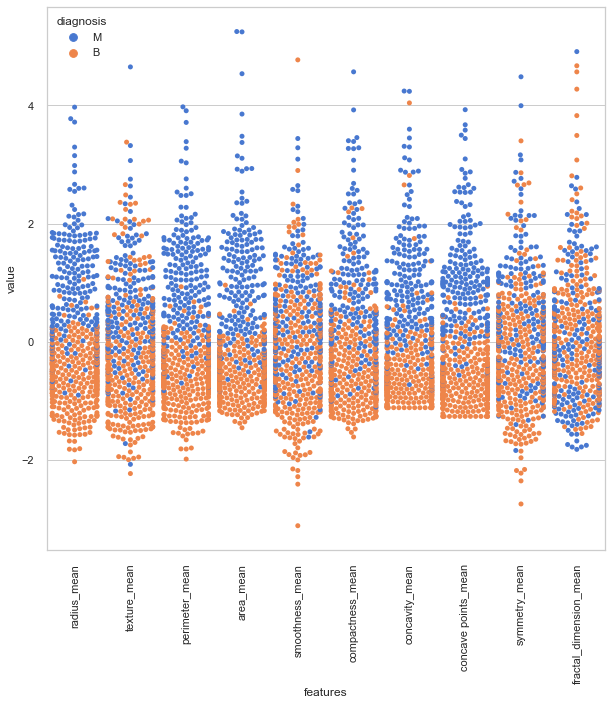

In [146]:
sns.set(style="whitegrid", palette="muted")
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([y,data_n_2.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
tic = time.time()
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)

plt.xticks(rotation=90)data = pd.concat([y,data_n_2.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=90)

C:\Users\Saket\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 65.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Saket\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 61.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Saket\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 66.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Saket\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 71.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Saket\AppData\Roaming\P

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'radius_se'),
  Text(1, 0, 'texture_se'),
  Text(2, 0, 'perimeter_se'),
  Text(3, 0, 'area_se'),
  Text(4, 0, 'smoothness_se'),
  Text(5, 0, 'compactness_se'),
  Text(6, 0, 'concavity_se'),
  Text(7, 0, 'concave points_se'),
  Text(8, 0, 'symmetry_se'),
  Text(9, 0, 'fractal_dimension_se')])

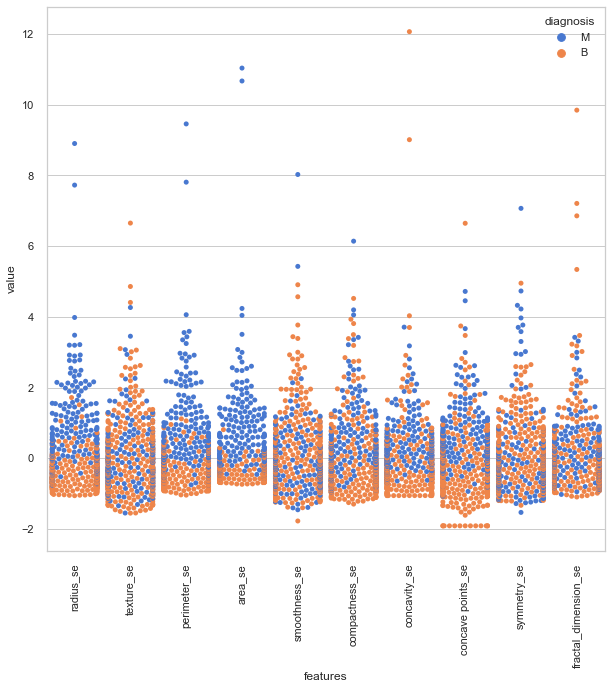

In [147]:
data = pd.concat([y,data_n_2.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=90)

C:\Users\Saket\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 47.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Saket\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 45.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Saket\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 48.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Saket\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 54.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Saket\AppData\Roaming\P

swarm plot time:  57.27935433387756  s


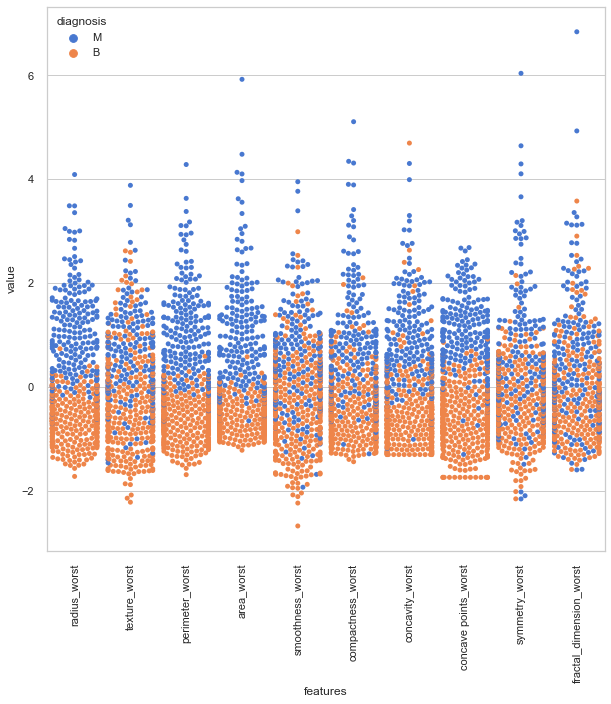

In [148]:


data = pd.concat([y,data_n_2.iloc[:,20:31]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
toc = time.time()
plt.xticks(rotation=90)
print("swarm plot time: ", toc-tic ," s")



In terms of classification, in the last swarm plot in area_worst, M and B look kind of separated
smoothness_Se in plot 2 looks like M and B are mixed so it is difficult to classify using this feature 